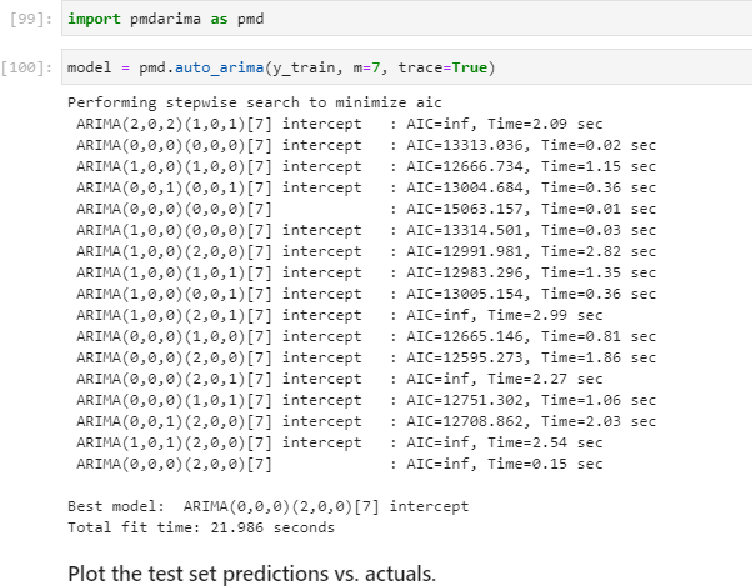<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# 9.02 Lab: Forecasting 

_Authors: Jeff Hale_

---

Let's practice univariate time series forecasting.

---

#### Data 

The Rossmann stores dataset.


#### Context

**You're the new data scientist for Rossman store number 863**. 

---

#### Goal
You manager tasks you with trying to build a model to predict how many customers the store will see in future days.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster 
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing


#### Explore the data and get it ready for modeling



In [2]:
rossman = pd.read_csv('./data/rossmann.csv')
rossman.head()

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
rossman.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
rossman['Date'] = pd.to_datetime(rossman['Date'])

In [5]:
rossman.set_index('Date', inplace = True)
rossman.sort_index(inplace = True)
rossman.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2013-01-01 to 2015-07-31
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


#### Filter to store 863

In [6]:
store = rossman[rossman['Store'] == 863]
store

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,863,2,0,0,0,0,a,1
2013-01-02,863,3,8279,1051,1,0,0,1
2013-01-03,863,4,6732,835,1,0,0,1
2013-01-04,863,5,8341,1029,1,0,0,1
2013-01-05,863,6,5582,666,1,0,0,0
...,...,...,...,...,...,...,...,...
2015-07-27,863,1,12344,1234,1,1,0,1
2015-07-28,863,2,10468,1103,1,1,0,1
2015-07-29,863,3,9782,1075,1,1,0,1


In [7]:
store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek      942 non-null    int64 
 2   Sales          942 non-null    int64 
 3   Customers      942 non-null    int64 
 4   Open           942 non-null    int64 
 5   Promo          942 non-null    int64 
 6   StateHoliday   942 non-null    object
 7   SchoolHoliday  942 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 66.2+ KB


<AxesSubplot:xlabel='Date'>

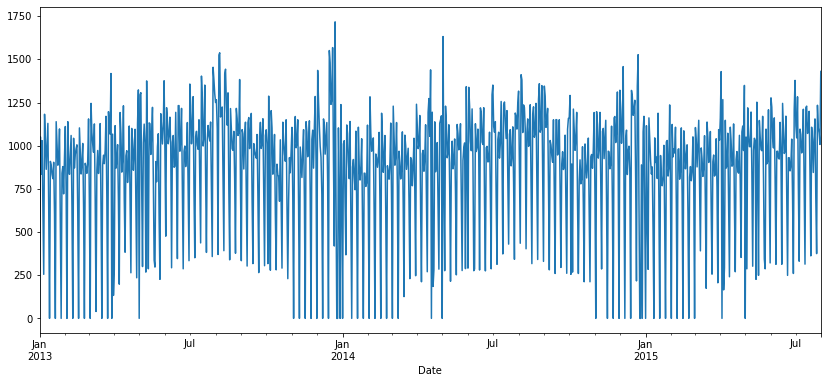

In [8]:
store['Customers'].plot(figsize = (14, 6))

#### If using sktime, the index needs converted to a period

In [9]:
store.index = store.index.to_period()

In [10]:
store.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 942 entries, 2013-01-01 to 2015-07-31
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek      942 non-null    int64 
 2   Sales          942 non-null    int64 
 3   Customers      942 non-null    int64 
 4   Open           942 non-null    int64 
 5   Promo          942 non-null    int64 
 6   StateHoliday   942 non-null    object
 7   SchoolHoliday  942 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 66.2+ KB


#### Set up y
⚠️ Add 1 to the number of customers for each observation so that Holt-Winters will work. Otherwise you will get an error because some values are 0.

In [11]:
store['Customers'] = np.where(store['Customers'] == 0, 1, store['Customers'])

<ipython-input-11-bdb41dfd4a5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store['Customers'] = np.where(store['Customers'] == 0, 1, store['Customers'])


In [12]:
y = store['Customers']
y

Date
2013-01-01       1
2013-01-02    1051
2013-01-03     835
2013-01-04    1029
2013-01-05     666
              ... 
2015-07-27    1234
2015-07-28    1103
2015-07-29    1075
2015-07-30    1007
2015-07-31    1430
Freq: D, Name: Customers, Length: 942, dtype: int64

#### Split the data into training and test sets. Make the most recent 30 days the test set.

In [13]:
y_train, y_test = temporal_train_test_split(y, test_size=30)

In [14]:
y_train.shape

(912,)

In [15]:
y_test.shape

(30,)

#### Plot the training and test set sales over time.

<AxesSubplot:title={'center':'Weekly Sales for Store 863'}, xlabel='Date'>

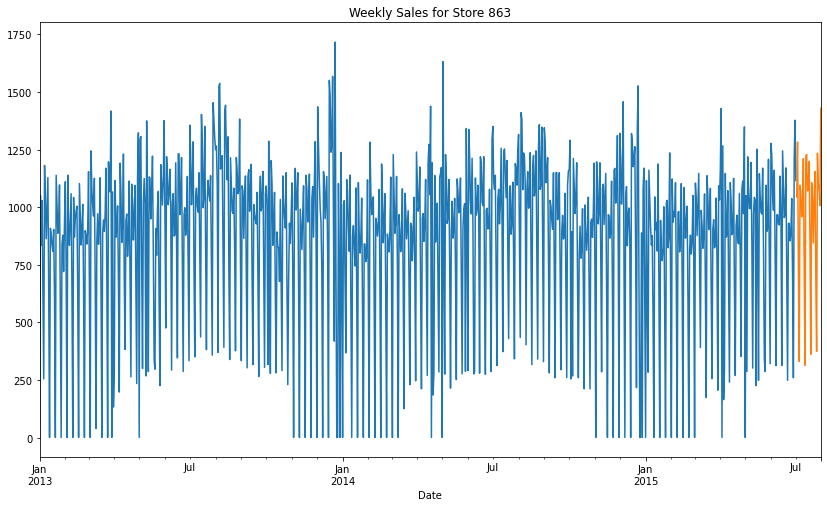

In [16]:
y_train.plot()
y_test.plot(figsize = (14, 8), title = 'Weekly Sales for Store 863')

#### Were those really 0 customers some days? Why else might some observations be 0?

The 0 customer days are very focused in the winter months - it could be holidays or weather.

## Baseline (naive) models

#### Make a baseline model that is the mean of the training data. 

You can do this manually, or with a library such as sktime.

In [17]:
naive_mean = NaiveForecaster(strategy='mean')
naive_mean.fit(y_train)

NaiveForecaster(strategy='mean')

In [18]:
naive_mean_preds = naive_mean.predict(list(range(1, len(y_test)+1)))
naive_mean_preds

2015-07-02    861.873904
2015-07-03    861.873904
2015-07-04    861.873904
2015-07-05    861.873904
2015-07-06    861.873904
2015-07-07    861.873904
2015-07-08    861.873904
2015-07-09    861.873904
2015-07-10    861.873904
2015-07-11    861.873904
2015-07-12    861.873904
2015-07-13    861.873904
2015-07-14    861.873904
2015-07-15    861.873904
2015-07-16    861.873904
2015-07-17    861.873904
2015-07-18    861.873904
2015-07-19    861.873904
2015-07-20    861.873904
2015-07-21    861.873904
2015-07-22    861.873904
2015-07-23    861.873904
2015-07-24    861.873904
2015-07-25    861.873904
2015-07-26    861.873904
2015-07-27    861.873904
2015-07-28    861.873904
2015-07-29    861.873904
2015-07-30    861.873904
2015-07-31    861.873904
Freq: D, dtype: float64

#### Plot the predictions on the test set and the actuals for the test set.


c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

''

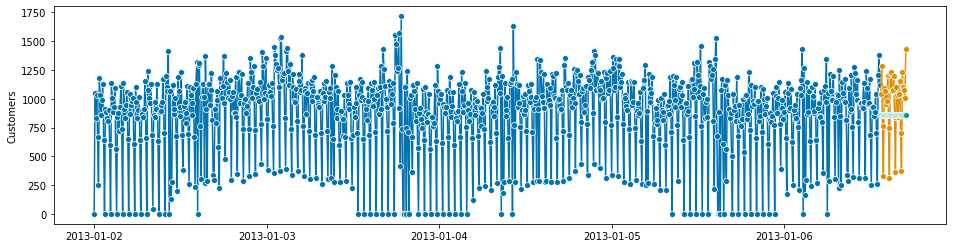

In [19]:
plot_series(y_train, y_test, naive_mean_preds)
;

#### Score your mean baseline model on the test set using Mean Absolute Error (MAE).

In [20]:
round(mae(y_test, naive_mean_preds), 0)

266.0

#### Make a seasonal baseline model. 

You can do this manually, or with a library such as sktime.

Think carefully about the optimal number of seasonal periods. Try a few different values for the number.

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

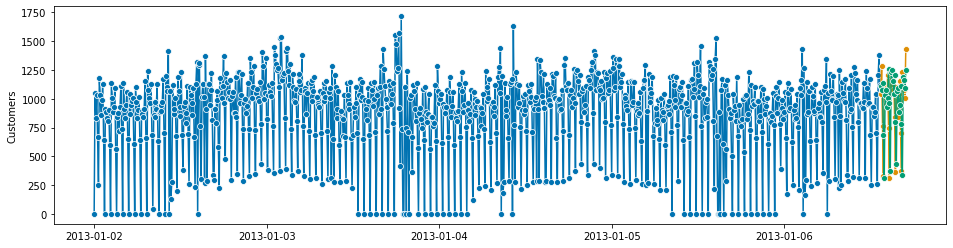

In [21]:
naive_seasonal = NaiveForecaster(strategy='last', sp=365)
naive_seasonal.fit(y_train)
naive_seasonal_preds = naive_seasonal.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, naive_seasonal_preds);

In [22]:
round(mae(y_test, naive_seasonal_preds), 0)

296.0

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

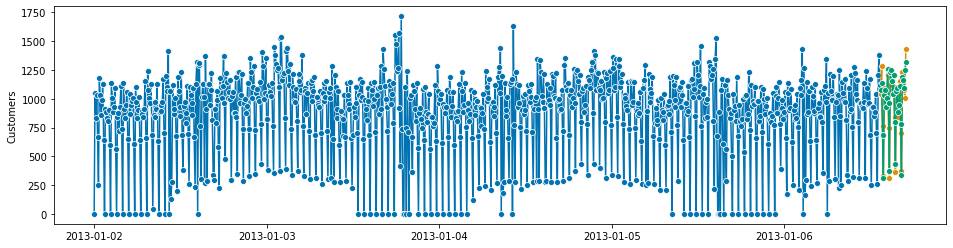

In [23]:
naive_seasonal = NaiveForecaster(strategy='last', sp=364)
naive_seasonal.fit(y_train)
naive_seasonal_preds = naive_seasonal.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, naive_seasonal_preds);

In [24]:
round(mae(y_test, naive_seasonal_preds), 0)

63.0

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

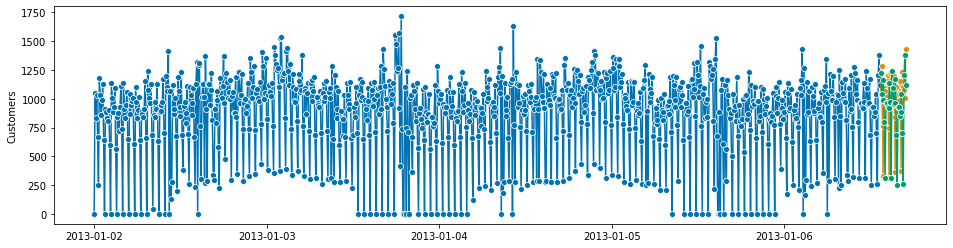

In [25]:
naive_seasonal = NaiveForecaster(strategy='last', sp=30)
naive_seasonal.fit(y_train)
naive_seasonal_preds = naive_seasonal.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, naive_seasonal_preds);

In [26]:
round(mae(y_test, naive_seasonal_preds), 0)

370.0

#### Which seasonal period value worked best?

One year worked best (364 days).

#### Why do you think that number worked best?

This number had the lowest mae score. I think this is because the store sales change over the course of the year, and using only a month of data is not enough.

## Holt-Winters

#### Make a model using Holt-Winters (triple exponential smoothing). 

Use statsmodels, pmdarima, or sktime. 

I suggest not using sktime's AutoETS, it hangs. If using skitme, the ExponentialSmoothing class with 7 or 364 seasonal periods should work. Try additive and multiplicative seasonality and trend.

In [27]:
# AutoETS hangs if use auto=True and predicts very poorly

# hw = AutoETS(sp=7, trend='add', seasonal='add')
# hw.fit(y_train.astype('float64'))      # AutoETS wants float64 for some reason. 
# hw_preds = hw.predict(list(range(1, len(y_test) + 1)))

In [28]:
hw = ExponentialSmoothing(
    y_train,
    seasonal_periods = 7,
    trend = 'mul',
    seasonal = 'add'
).fit()

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [29]:
hw.summary()

Dep. Variable:,Customers,No. Observations:,912
Model:,ExponentialSmoothing,SSE,40891535.088
Optimized:,True,AIC,9790.244
Trend:,Multiplicative,BIC,9843.216
Seasonal:,Additive,AICC,9790.649
Seasonal Periods:,7,Date:,"Tue, 25 May 2021"
Box-Cox:,False,Time:,16:57:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0757143,alpha,True
smoothing_trend,0.0432653,beta,True


In [30]:
hw_preds = hw.forecast(len(y_test))

#### Plot the test set predictions vs. actuals.
Don't plot the training set, so you can see the results better.

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

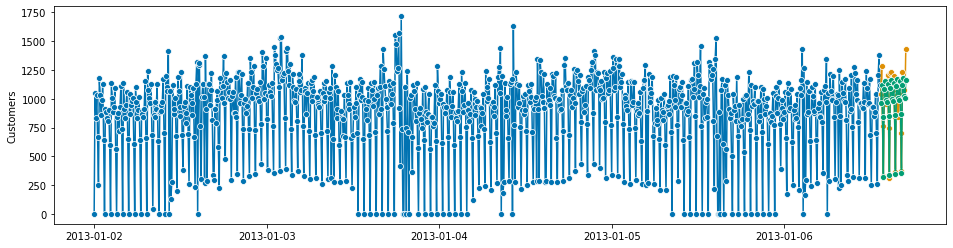

In [31]:
plot_series(y_train, y_test, hw_preds);

#### Score your models on the test set using MAE. 

In [32]:
round(mae(y_test, hw_preds), 0)

73.0

#### Second HW model:

In [33]:
hw = ExponentialSmoothing(
    y_train,
    seasonal_periods = 364,
    trend = 'add',
    seasonal = 'mul'
).fit()

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [34]:
hw.summary()

Dep. Variable:,Customers,No. Observations:,912
Model:,ExponentialSmoothing,SSE,20927283927.840
Optimized:,True,AIC,16193.196
Trend:,Additive,BIC,17965.351
Seasonal:,Multiplicative,AICC,16700.663
Seasonal Periods:,364,Date:,"Tue, 25 May 2021"
Box-Cox:,False,Time:,16:57:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0050000,alpha,True
smoothing_trend,0.0001,beta,True


In [35]:
hw_preds = hw.forecast(len(y_test))

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

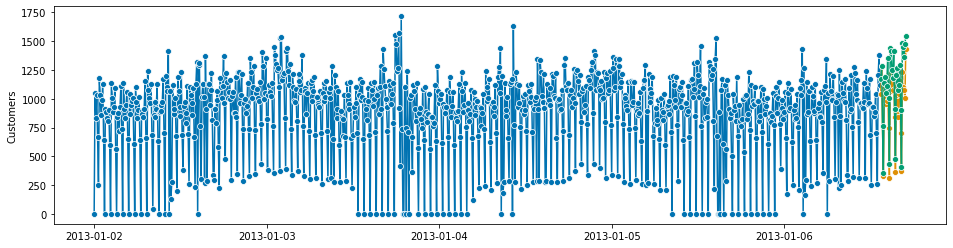

In [36]:
plot_series(y_train, y_test, hw_preds);

In [37]:
round(mae(y_test, hw_preds), 0)

155.0

#### How did your best Holt-Winters model perform?

Not great - worse than the naive models.

## SARIMA
#### Make a SARIMA model. 
Use statsmodels, pmdarima, or sktime. 

Advice: don't try 364 for a seasonal period. Stick with 7. 364 hangs or performs poorly. If using sktime or pmdarima, you might be able to make a better model by manually adjusting the hyperparameters after automatically hyperparameter searching. The ARIMA class from sktime will let you adjust hyperparameters

In [38]:
import pmdarima as pmd

In [39]:
model = pmd.auto_arima(y_train, m=7, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13313.036, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=12666.734, Time=1.03 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13004.684, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=15063.157, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=13314.501, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=12991.981, Time=2.97 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=12983.296, Time=1.27 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=13005.154, Time=0.38 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=12665.146, Time=0.78 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=12595.273, Time=1.86 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=12751.302, Time=1.16 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   :

#### Plot the test set predictions vs. actuals.

In [40]:
sarima_preds = model.predict(y_test.shape[0])
sarima_preds = pd.Series(sarima_preds, index = y_test.index)
sarima_preds

Date
2015-07-02     921.182871
2015-07-03    1043.004591
2015-07-04     763.600227
2015-07-05     457.240038
2015-07-06    1027.734390
2015-07-07    1089.961276
2015-07-08     968.820046
2015-07-09     907.799598
2015-07-10    1001.672809
2015-07-11     790.695753
2015-07-12     533.435912
2015-07-13    1051.560300
2015-07-14    1129.333476
2015-07-15     999.677968
2015-07-16     913.968245
2015-07-17     988.078773
2015-07-18     819.695326
2015-07-19     625.519851
2015-07-20    1001.490650
2015-07-21    1050.327347
2015-07-22     963.262448
2015-07-23     911.895098
2015-07-24     969.656224
2015-07-25     839.168914
2015-07-26     684.160479
2015-07-27     990.789058
2015-07-28    1034.017798
2015-07-29     959.871128
2015-07-30     913.134220
2015-07-31     958.460023
Freq: D, dtype: float64

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

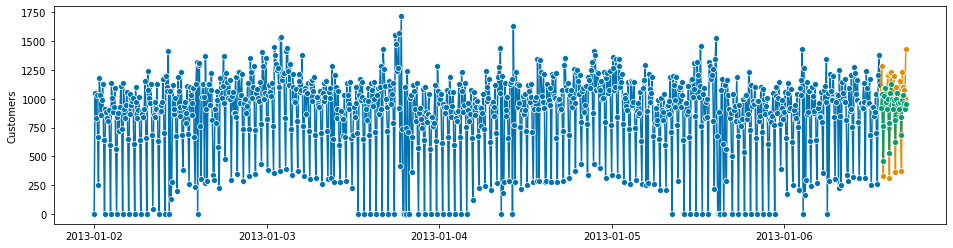

In [41]:
plot_series(y_train, y_test, sarima_preds);

#### Score your model on the test set using MAE. 

In [42]:
round(mae(y_test, sarima_preds), 0)

138.0

#### How did that model do?

Not great.

#### Manual SARIMA

In [44]:
model = pmd.auto_arima(
    y_train, 
    start_p=0, 
    start_q=0,
    max_p=2,
    max_q=2,
    d=0,
    start_P=2, 
    start_Q=0,
    max_P=2,                
    max_Q=2,
    seasonal=True, 
    m=7,
    error_action='ignore',
    suppress_warnings=True,
)


In [45]:
sarima_preds2 = model.predict(y_test.shape[0])
sarima_preds2 = pd.Series(sarima_preds2, index = y_test.index)
sarima_preds2

Date
2015-07-02     921.182871
2015-07-03    1043.004591
2015-07-04     763.600227
2015-07-05     457.240038
2015-07-06    1027.734390
2015-07-07    1089.961276
2015-07-08     968.820046
2015-07-09     907.799598
2015-07-10    1001.672809
2015-07-11     790.695753
2015-07-12     533.435912
2015-07-13    1051.560300
2015-07-14    1129.333476
2015-07-15     999.677968
2015-07-16     913.968245
2015-07-17     988.078773
2015-07-18     819.695326
2015-07-19     625.519851
2015-07-20    1001.490650
2015-07-21    1050.327347
2015-07-22     963.262448
2015-07-23     911.895098
2015-07-24     969.656224
2015-07-25     839.168914
2015-07-26     684.160479
2015-07-27     990.789058
2015-07-28    1034.017798
2015-07-29     959.871128
2015-07-30     913.134220
2015-07-31     958.460023
Freq: D, dtype: float64

c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lindsey\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

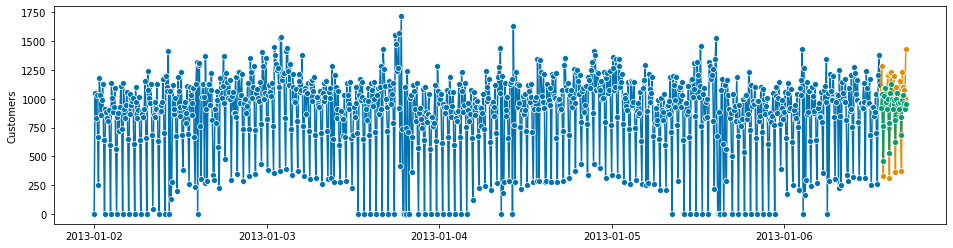

In [46]:
plot_series(y_train, y_test, sarima_preds2);

In [47]:
round(mae(y_test, sarima_preds2), 0)

138.0

---
## ⭐️ Bonus: SARIMAX

It is possible to create a model that beats the seasonal baseline by including StateHoliday and Promo as exogenous variables.


#### Bonus, not required: Make a SARIMAX model that uses *StateHoliday* and *Promo* for X. Use statsmodels, pmdarima, or sktime. 

You'll need to read in the data, clean it a bit, set up X and y, and train-test-split. I suggest making StateHoliday binary. For SARIMA, 364 likely won't work for seasonal periods, so keep it to 7.

#### Plot the test set predictions vs. actuals.

#### Score your models on the test set using MAE. 

#### Which model performs best?